In [1]:
from __init__ import PRP; import sys
sys.path.append(PRP)

from scripts.grad_compare import *
from scripts.utils import *

from setups.acc.acc_learning import ACCSetup
from tqdm import tqdm
import gc 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn

from jax import lax

/home/emeunier/code/Veros-Autodiff/
Differentiable Veros Experimental version
Importing core modules
 Using computational backend jax on gpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



2025-10-15 09:26:05.271257: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.9.86). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Spin-up

In [2]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()


def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

# Spin-up 
acc = ACCSetup()
acc.setup()

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075
Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 200/200 [00:24<00:00,  8.30it/s]


Backward vjp - Directional Gradients

# Methods

In [6]:
#direction = jax.random.normal(jax.random.PRNGKey(0), acc.state.variables.u.shape)
#direction = direction / jnp.linalg.norm(direction)  # normalize


#
var_dev = 'r_bot'
random = 'ones'

direction = jnp.zeros_like(getattr(state.variables, var_dev))
if random == 'normal' :
    direction = jax.random.normal(jax.random.PRNGKey(0), direction.shape)
elif random == 'uniform' :
    direction = jax.random.uniform(jax.random.PRNGKey(0), direction.shape)
elif random == 'ones' :
    direction = jnp.ones_like(direction)
    
# if len(direction.shape) > 0 : 
#     direction = direction.at[:,:,:,state.variables.tau].set(jax.random.normal(jax.random.PRNGKey(0), direction[:,:,:,state.variables.tau].shape))

direction = direction / jnp.linalg.norm(direction)


var_agg = 'u'
def agg_sum(state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    return ((getattr(state.variables, key_sum))**2).sum()
    
agg_function = lambda state : agg_sum(state, key_sum=var_agg)

In [7]:
direction

Array(1., dtype=float64)

In [8]:
vjpm = vjp_grad(acc.step, agg_function, var_dev)


vjpm.step_function = jax.jit(vjpm.step_function)
vjpm.agg_function = jax.jit(vjpm.agg_function)

loss_and_grad = lambda s, v, it: vjpm.g(s, v, iterations=it)

In [9]:
%%time
state = state.copy()
field = jnp.array(1e-5, dtype=jnp.float64) #getattr(state.variables, var_dev)

output_forward, gradients = loss_and_grad(state, field, it=2)

CPU times: user 1min 30s, sys: 2.8 s, total: 1min 33s
Wall time: 1min 48s


In [11]:
def dir_der_autodiff(state, field, direction, loss_and_grad, iterations) :
    output_forward, gradients = loss_and_grad(state, field, it=iterations)
    analytical_dir_deriv = jnp.sum(gradients * direction)
    return output_forward, analytical_dir_deriv

In [12]:
%%time
dir_der_autodiff(state, field, direction, loss_and_grad, iterations=2)

CPU times: user 1.93 s, sys: 56.7 ms, total: 1.99 s
Wall time: 1.93 s


(Array(24.97432923, dtype=float64), Array(10121.03165375, dtype=float64))

In [13]:

class numerical_diff_tensor(autodiff) :

    @staticmethod
    def perturb(field, direction, epsilon= 1e-4) : 
        field_pert = field.copy() + epsilon * direction
        return field_pert

    def g(self, state, var_value, direction, iterations=1, epsilon=1e-9, **kwargs) :

        forward = partial(autodiff.wrapper,
                        state=state,
                        step_fun=self.step_function,
                        var_name=self.var_name,
                        agg_func=self.agg_function,
                        iter=iterations)

        field_plus = self.perturb(var_value, direction, epsilon)
        f_plus = forward(field_plus)
        
        field_minus = self.perturb(var_value, -direction, epsilon)
        f_minus = forward(field_minus)
        
        numerical_dir_deriv = (f_plus - f_minus) / (2 * epsilon)

        return (f_plus + f_minus)/2, numerical_dir_deriv
        

Numerical diff

In [14]:
# Numerical directional derivative check for the full tensor

ndm = numerical_diff_tensor(acc.step, agg_function, var_dev)

ndm.step_function = jax.jit(ndm.step_function)
ndm.agg_function = jax.jit(ndm.agg_function)

In [15]:
%%time
ndm.g(state, field, direction, iterations=2, epsilon=1e-5)

CPU times: user 17.2 s, sys: 349 ms, total: 17.6 s
Wall time: 14.3 s


(Array(24.99473882, dtype=float64), Array(-8255.87879778, dtype=float64))

In [69]:
direction

Array(1., dtype=float64)

# Precision vs. iteration

In [ ]:
stats = []

for nitt in range(100) :
    s = {'n_iteration' : nitt}
    s['autodiff_loss'], s['autodiff_grad'] = dir_der_autodiff(state, field, direction, loss_and_grad, iterations=nitt)
    
    s['numerical_loss'], s['numerical_grad'] = ndm.g(state, field, direction, iterations=nitt, epsilon=1e-4)
    stats.append(s)
    print(s)

{'n_iteration': 0, 'autodiff_loss': Array(2186947.96029149, dtype=float64), 'autodiff_grad': Array(2067.91708991, dtype=float64), 'numerical_loss': Array(2186947.9602915, dtype=float64), 'numerical_grad': Array(2067.91708944, dtype=float64)}
{'n_iteration': 1, 'autodiff_loss': Array(2185782.44001271, dtype=float64), 'autodiff_grad': Array(2060.49872643, dtype=float64), 'numerical_loss': Array(2185782.44000242, dtype=float64), 'numerical_grad': Array(2060.48557768, dtype=float64)}
{'n_iteration': 2, 'autodiff_loss': Array(2184658.30488528, dtype=float64), 'autodiff_grad': Array(2057.54693207, dtype=float64), 'numerical_loss': Array(2184658.31060665, dtype=float64), 'numerical_grad': Array(2057.69091379, dtype=float64)}
{'n_iteration': 3, 'autodiff_loss': Array(2183527.05171483, dtype=float64), 'autodiff_grad': Array(2053.94086819, dtype=float64), 'numerical_loss': Array(2183527.05907912, dtype=float64), 'numerical_grad': Array(2053.60129941, dtype=float64)}
{'n_iteration': 4, 'autodiff_

In [154]:
stats = pd.DataFrame(stats)
stats = stats.melt(id_vars='n_iteration')
stats['value'] = stats['value'].apply(lambda x : x.item())
stats_g =stats.pivot(columns='variable', index='n_iteration', values='value').reset_index()
stats_g['accuracy'] = 1 - np.abs((stats_g['autodiff_grad'] - stats_g['numerical_grad'])/stats_g['numerical_grad'])

In [165]:
stats_gf =  stats_g.melt(id_vars='n_iteration')

In [168]:
stats_gf

,n_iteration,variable,value
0,0,autodiff_grad,2.067917e+03
1,1,autodiff_grad,2.060499e+03
2,2,autodiff_grad,2.057547e+03
3,3,autodiff_grad,2.053941e+03
4,4,autodiff_grad,2.050428e+03
5,0,autodiff_loss,2.186948e+06
6,1,autodiff_loss,2.185782e+06
7,2,autodiff_loss,2.184658e+06
8,3,autodiff_loss,2.183527e+06
9,4,autodiff_loss,2.182398e+06


Text(0.5, 0, 'Number of iterations')

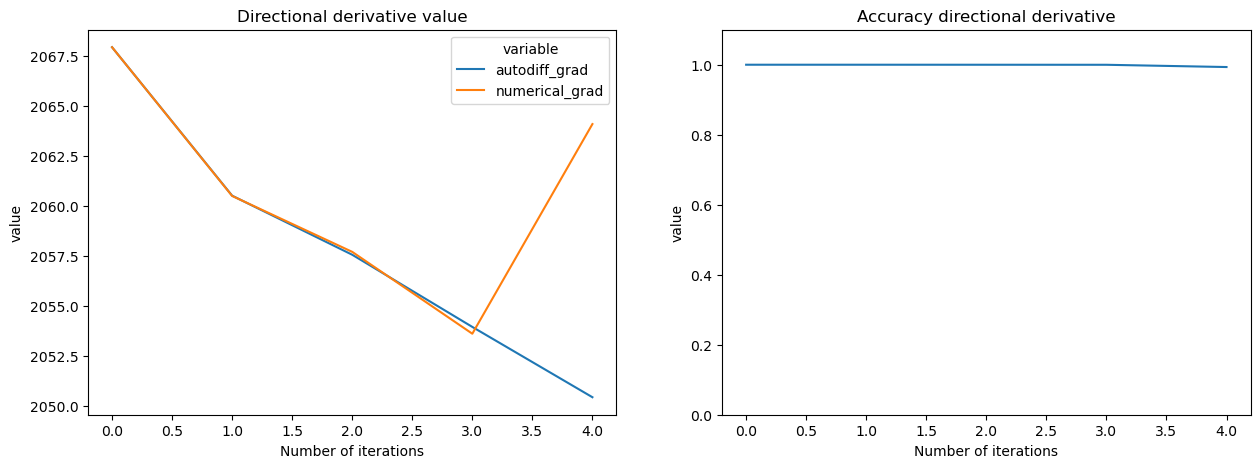

In [172]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(data=stats_gf.query('n_iteration < 5 and variable != "accuracy" and variable.str.contains("grad")', engine='python'),
             x='n_iteration', y='value', hue='variable', ax=axs[0])
axs[0].set_title('Directional derivative value')
axs[0].set_xlabel('Number of iterations')
sns.lineplot(data=stats_gf.query('n_iteration < 5 and variable == "accuracy"'),
             x='n_iteration', y='value', ax=axs[1])
axs[1].set_title('Accuracy directional derivative')
axs[1].set_ylim([0,1.1])
axs[1].set_xlabel('Number of iterations')
#fig.savefig(f'figures/directional_derivative_accuracy_{datetime.now().strftime("%d%m%y")}.png')

In [171]:
stats_gf.query('n_iteration < 5 and variable != "accuracy" and variable.str.contains("grad")', engine='python')

,n_iteration,variable,value
0,0,autodiff_grad,2067.917090
1,1,autodiff_grad,2060.498726
2,2,autodiff_grad,2057.546932
3,3,autodiff_grad,2053.940868
4,4,autodiff_grad,2050.427905
10,0,numerical_grad,2067.917089
11,1,numerical_grad,2060.485578
12,2,numerical_grad,2057.690914
13,3,numerical_grad,2053.601299
14,4,numerical_grad,2064.077528


In [ ]:
w